In [1]:
import json
import numpy as np
import sys
np.random.seed(0) # set a seed to enable reproducable results
import pandas as pd
import geopandas as gpd
import random
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

# 1. Preparo dos Dataset

In [2]:
df = gpd.read_file('BRMUE250GC_SIR.dbf')

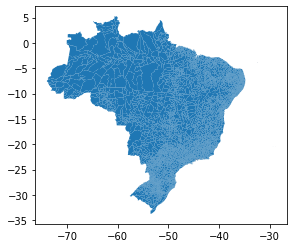

In [3]:
df.plot()

### 1.1 Mapeamento dos Estados
Os Estados são identificados por números inteiros padronizados pelo IBGE. Aqui fazemos o mapeamento para melhor visualização.

In [4]:
df['STATE'] = df['CD_GEOCMU'].apply(lambda x: x[:2])

In [5]:
states = {'11': 'RONDÔNIA',
'12': 'ACRE',
'13': 'AMAZONAS',
'14': 'RORAIMA',
'15': 'PARÁ',
'16': 'AMAPÁ',
'17': 'TOCANTINS',
'21': 'MARANHÃO',
'22': 'PIAUÍ',
'23': 'CEARÁ',
'24': 'RIO GRANDE DO NORTE',
'25': 'PARAÍBA',
'26': 'PERNAMBUCO',
'27': 'ALAGOAS',
'28': 'SERGIPE',
'29': 'BAHIA',
'31': 'MINAS GERAIS',
'32': 'ESPIRITO SANTO',
'33': 'RIO DE JANEIRO',
'35': 'SÃO PAULO',
'41': 'PARANÁ',
'42': 'SANTA CATARINA',
'43': 'RIO GRANDE DO SUL',
'50': 'MATO GROSSO DO SUL',
'51': 'MATO GROSSO',
'52': 'GOIÁS',
'53': 'DISTRITO FEDERAL'}


In [6]:
df = df.replace({"STATE": states})

### 1.2 Criação de cores
Futuramente descobri que esses valores de cor não são aplicados no mapa plotado, mas elas garantem que estados vizinhos não terão cores idênticas no plot

In [7]:
number_of_colors = 27

color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]

In [8]:
df.loc[:,'COLOR'] = df.loc[:,'STATE']

dict_colors = {'RONDÔNIA': '#93859E',
'ACRE': '#44B1F0',
'AMAZONAS': '#DEC3FE',
'RORAIMA': '#696E18',
'PARÁ': '#0BAA93',
'AMAPÁ': '#8EAC7E',
'TOCANTINS': '#D5FF12',
'MARANHÃO': '#9C2454',
'PIAUÍ': '#5D5980',
'CEARÁ': '#CAD17D',
'RIO GRANDE DO NORTE': '#CA2412',
'PARAÍBA': '#47B90F',
'PERNAMBUCO': '#2E3804',
'ALAGOAS': '#25740A',
'SERGIPE': '#A0C80B',
'BAHIA': '#ADBDD6',
'MINAS GERAIS': '#FCBBA1',
'ESPIRITO SANTO': '#1021C8',
'RIO DE JANEIRO': '#5F1B8A',
'SÃO PAULO': '#B20804',
'PARANÁ': '#19B282',
'SANTA CATARINA': '#286A8D',
'RIO GRANDE DO SUL': '#552E10',
'MATO GROSSO DO SUL': '#054383',
'MATO GROSSO': '#A3B20C',
'GOIÁS': '#2AEA30',
'DISTRITO FEDERAL':'#0FEDB3'}


df = df.replace({'COLOR': dict_colors})

# 2. Visualização dos Estados na configuração Real

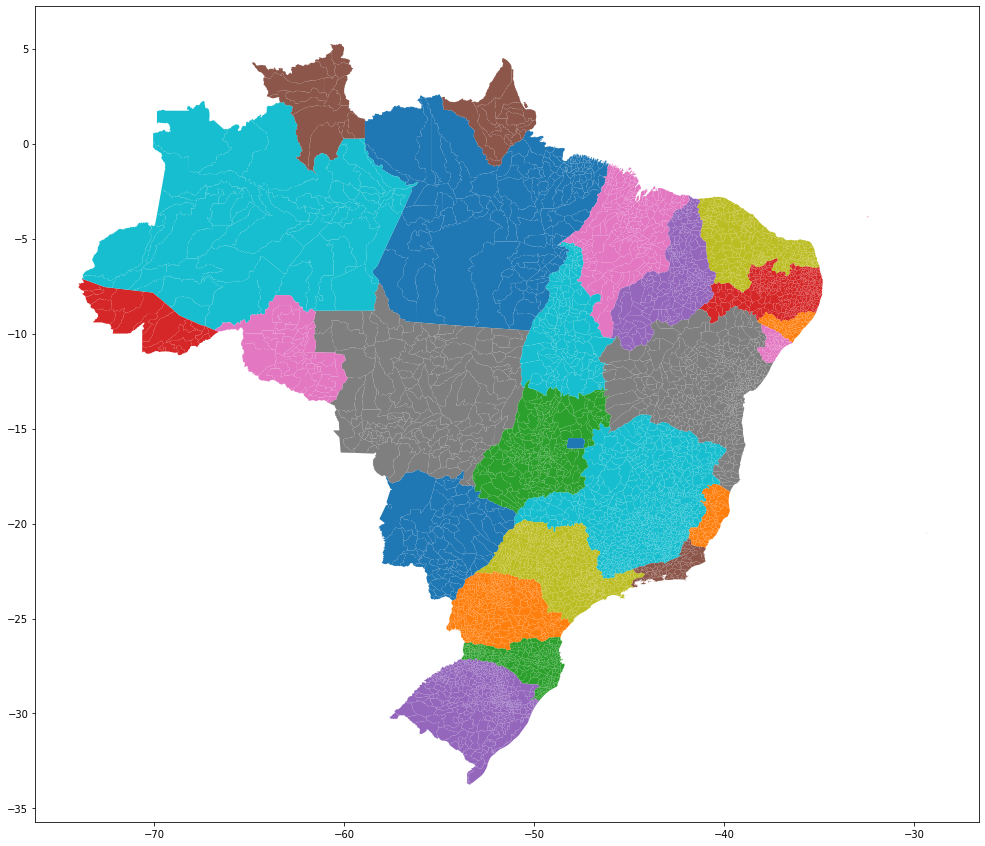

In [9]:
df.plot(figsize=(20,15), edgecolor="none", column=df['COLOR'])

# 3. Criação de um Dataset treinável
O nosso dataset original contém objetos Polygon ou MultiPolygon, que estão despadronizados em dimensão. Para qualquer treinamento, precisamos tornar todos os atributos dimensionalmente idênticos. Fazemos isso extraindo todo o conjunto [LAT,LNG] que compõem as cidades.

In [11]:
df_treinavel = pd.DataFrame()

for row in df.iterrows():
    sys.stdout.write('\r' + str(row[0]))
    if row[1]['geometry'].type == 'Polygon':
        x,y = row[1]['geometry'].exterior.coords.xy
        model_df = pd.DataFrame()
        model_df['LAT'] = y
        model_df['LNG'] = x
        model_df['NM_MUNICIP'] = row[1]['NM_MUNICIP']
        model_df['CD_GEOCMU'] = row[1]['CD_GEOCMU']
        model_df['STATE'] = row[1]['STATE']
        df_treinavel = pd.concat([df_treinavel, model_df])
    else:
        for polig in row[1]['geometry']:
            x,y = polig.exterior.coords.xy
            model_df = pd.DataFrame()
            model_df['LAT'] = y
            model_df['LNG'] = x
            model_df['NM_MUNICIP'] = row[1]['NM_MUNICIP']
            model_df['CD_GEOCMU'] = row[1]['CD_GEOCMU']
            model_df['STATE'] = row[1]['STATE']
            df_treinavel = pd.concat([df_treinavel, model_df])
            

5571

In [12]:
df_treinavel.to_csv('df_treinavel.tsv', sep='\t', index = 0)

**Extraímos uma parcela das cidades a serem usadas para treino. As cidades restantes iriam compor a parcela de teste, para avaliação dos modelos, mas aqui iremos ignorar esta parcela. O nosso teste será visual, na construção dos estados no mapa**

In [13]:
cities = df['CD_GEOCMU'].values 

In [14]:
training_value = int(len(cities) * 70 / 100) + 1
# testing_value = int(len(cities) * 30 / 100)

cities_for_training = random.sample(list(cities), training_value)
# cities_for_testing = [c for c in cities if c not in cities_for_training]

In [16]:
df_train = df_treinavel[df_treinavel['CD_GEOCMU'].isin(cities_for_training)]
# df_test = new_df[new_df['CD_GEOCMU'].isin(cities_for_testing)]

In [17]:
X_train, y_train = df_train.loc[:, ['LAT', 'LNG']], df_train.loc[:, 'STATE']
# X_test, y_test = df_test.loc[:, ['LAT', 'LNG']], df_test.loc[:, 'STATE']

# 4. Underfit
Aqui usaremos um modelo de classificação baseado em Árvores de Decisão, e iremos forçar o underfit limitando a quantidade de features a serem consideradas e a profundidade da árvore.

In [19]:
clf = RandomForestClassifier(min_samples_leaf=50, max_depth=3, random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=50, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [20]:
for i, city in enumerate(df['CD_GEOCMU']):
    sys.stdout.write('\r' + str(i))
    predictions = clf.predict(df_treinavel[df_treinavel['CD_GEOCMU'] == city].loc[:, ['LAT', 'LNG']])
    predicted_state = np.unique(predictions, return_counts=True)[0][0]
    df.loc[df[df['CD_GEOCMU'] == city].index[0], 'UNDER_PREDICTED_STATE'] = predicted_state

5571

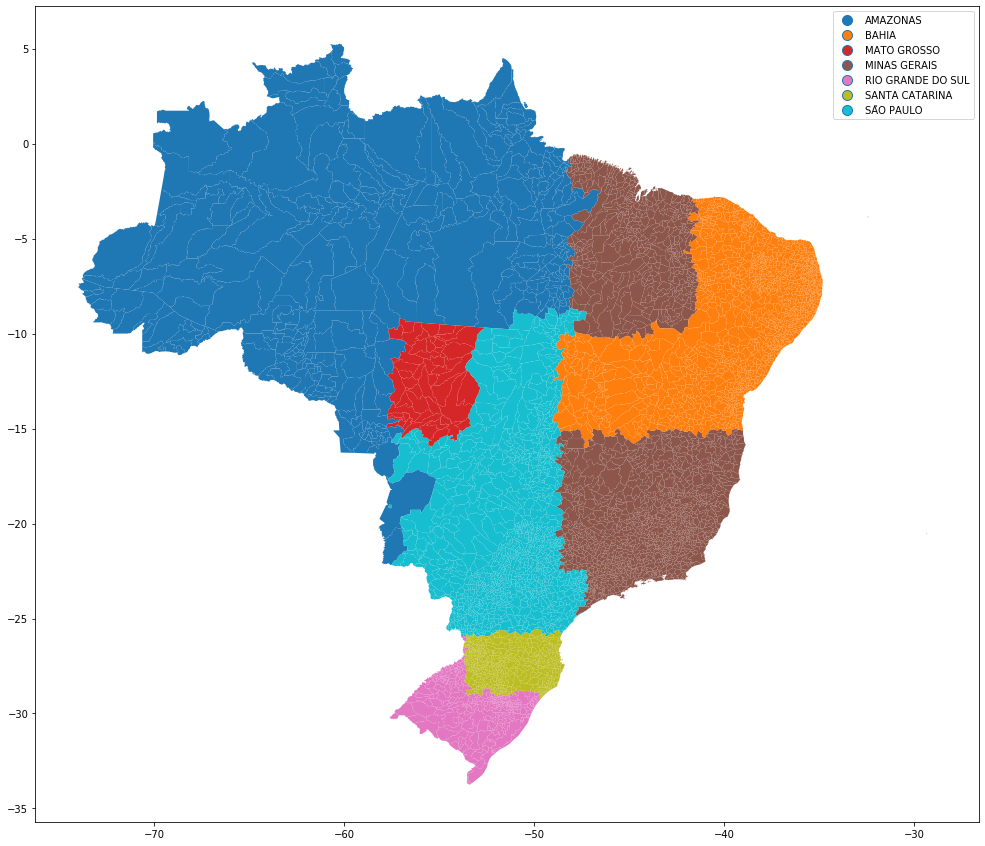

In [21]:
df.plot(figsize=(20,15), edgecolor="none", column=df['PREDICTED_STATE'])

# 5. Overfit
Permitindo que o modelo leia todos os exemplos disponíveis induz o overfitting das suas previsões, e iremos aliar isso com um modelo que não possui controle de profundidade e samples, permitindo árvores extremamente profundas e propensas a especificidades - o que também favorece um overfitting.

In [27]:
X = df_treinavel.loc[:, ['LAT', 'LNG']]
y = df_treinavel.loc[:, 'STATE']

In [28]:
clf = RandomForestClassifier()
clf.fit(X, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [29]:
for i, city in enumerate(df['CD_GEOCMU']):
    sys.stdout.write('\r' + str(i))
    predictions = clf.predict(df_treinavel[df_treinavel['CD_GEOCMU'] == city].loc[:, ['LAT', 'LNG']])
    predicted_state = np.unique(predictions, return_counts=True)[0][0]
    df.loc[df[df['CD_GEOCMU'] == city].index[0], 'OVER_PREDICTED_STATE'] = predicted_state

5571

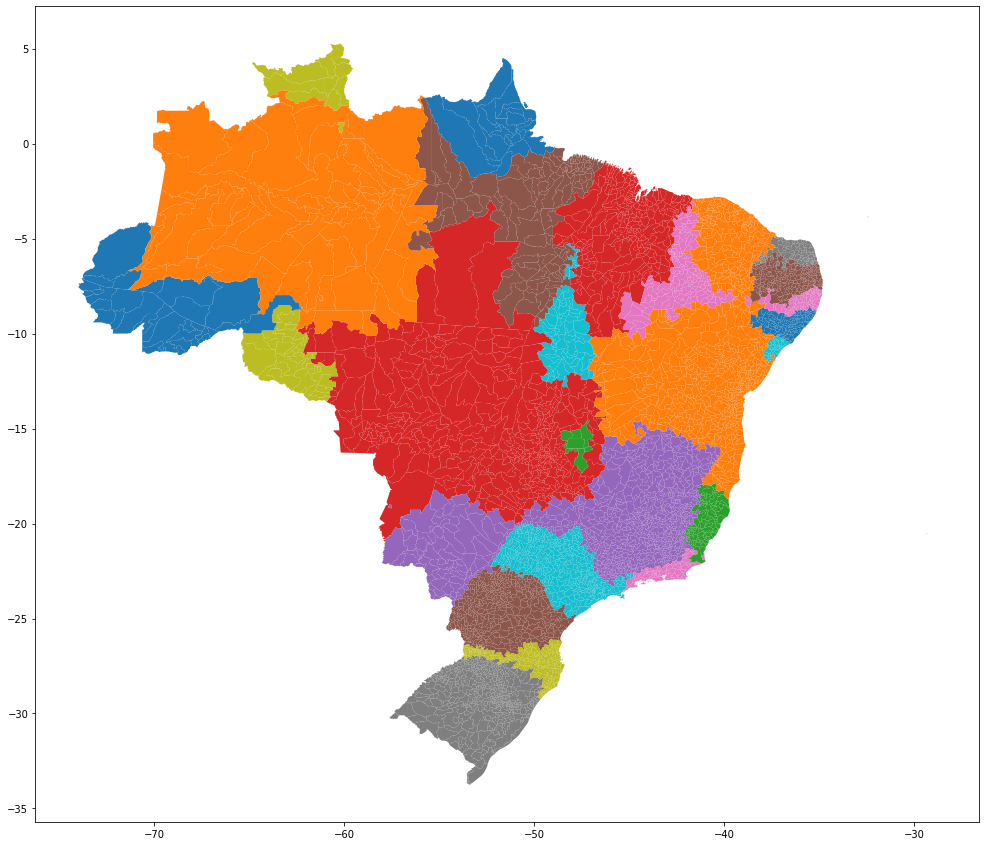

In [34]:
df.plot(figsize=(20,15), edgecolor="none", column=df['OVER_PREDICTED_STATE'])

# 6. Resultado

In [ ]:
fig, axes = plt.subplots(ncols=3, figsize=(25,20))

# add geopandas plot to left subplot
df.plot(edgecolor="none", column=df['COLOR'], ax=axes[0])
df.plot(edgecolor="none", column=df['UNDER_PREDICTED_STATE'], ax=axes[1])
df.plot(edgecolor="none", column=df['OVER_PREDICTED_STATE'], ax=axes[2])